#Analysis Using GBRT on Central Car Auction Data

**Data Source**
Webpage:  http://www.centralcarauctions.com/trade/vehicles/price-guide/price-guide?page=1

Date Accessed: July 2014 

Analysis Method: Gradient Boosted Regression Trees (GBRT)

Steps in this notebook: 

1. Read in prepreoced encoded data.   
2. Perform a basic GBRT run and view Feature Importance.


## Imports and Setup

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble, cross_validation as cv
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [2]:
# Coloring / Styling
sns.set_style('darkgrid')
sns.set_context('talk')

## Read in  Data

In [3]:
# Read in Data file 
df_enc = pd.read_csv('car_auction_enc.csv')

In [4]:
# Select features
features = ['model', 'year_ord', 'mileage', 'MOT_ord', 'make', 'class']
target = ['price']

# Extract Values
X = df_enc[features].values.astype(float)
y = df_enc[target].values.ravel().astype(float)

# Investigate the Loss Function

This section primarily looks at the effect of the differnt loss functions:

* Least Absolute difference (lad)
* Least Squares (ls)
* A combination of the two above (huber)

Each are investiagetd by running a 5 fold cross validation and visualising the residuals on each test set.

Performace was measured using mean squared error (MSE) and mean absolute error (MAE) of the predictions on the test set. 

The huber loss function performed the best on this data with a combined Mean Absolute Error Score of **715.04** with standard deviation **52.94**.

In [5]:
### Model Batch Parameters
params_list = [{'n_estimators': 1000, 'max_depth': 3, 'min_samples_split': 5,
          'learning_rate': 0.1, 'loss': 'lad'}, 
               {'n_estimators': 1000, 'max_depth': 3, 'min_samples_split': 5,
          'learning_rate': 0.1, 'loss': 'ls'}, 
               {'n_estimators': 1000, 'max_depth': 3, 'min_samples_split': 5,
          'learning_rate': 0.1, 'loss': 'huber'}]

### Cross Validation 


For Parameter set 1: Loss function = lad

Fold 0: Mean Absolute Error: 647.45   Std: 1029.35
Fold 1: Mean Absolute Error: 666.70   Std: 901.32
Fold 2: Mean Absolute Error: 814.97   Std: 1428.71
Fold 3: Mean Absolute Error: 680.88   Std: 1001.13
Fold 4: Mean Absolute Error: 683.07   Std: 996.44

Combined Mean Absolute Error Scores: 698.61    Std:  59.55

For Parameter set 2: Loss function = ls

Fold 0: Mean Absolute Error: 591.76   Std: 855.30
Fold 1: Mean Absolute Error: 565.39   Std: 624.26
Fold 2: Mean Absolute Error: 683.44   Std: 1155.76
Fold 3: Mean Absolute Error: 585.34   Std: 724.60
Fold 4: Mean Absolute Error: 591.71   Std: 692.84

Combined Mean Absolute Error Scores: 651.07    Std:  69.85

For Parameter set 3: Loss function = huber

Fold 0: Mean Absolute Error: 579.56   Std: 857.46
Fold 1: Mean Absolute Error: 561.67   Std: 658.28
Fold 2: Mean Absolute Error: 685.05   Std: 1197.31
Fold 3: Mean Absolute Error: 575.02   Std: 773.84
Fold 4: Mean Absolute Error: 568.89   Std: 69

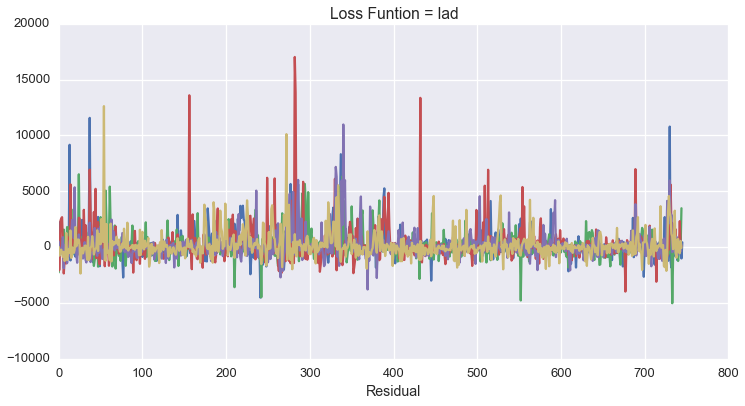

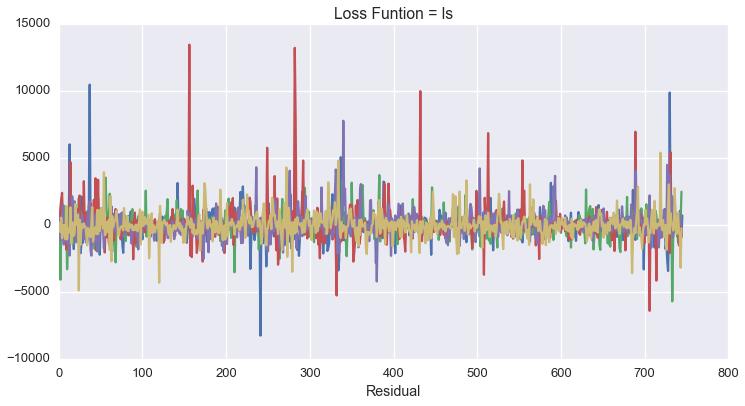

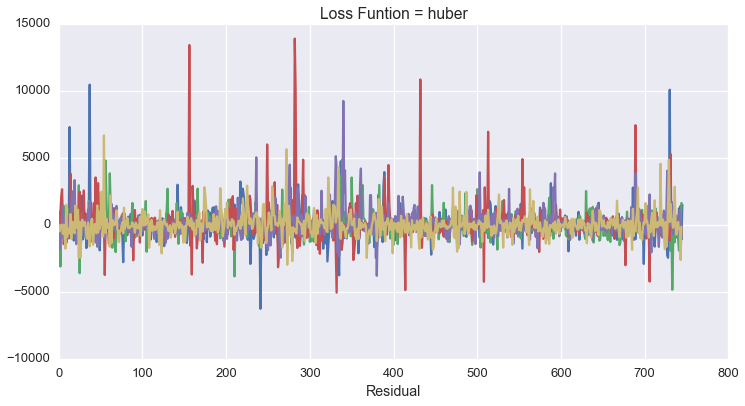

In [6]:
# Initialise Data Structures
MSE_list = []
MAE_list = []

folds = 5

for param_no, params in enumerate(params_list[:3]):
    
    print('\nFor Parameter set {}: Loss function = {}\n'.format(param_no + 1, params['loss']))
    
    plt.figure(figsize=(12,6))
    
    # K fold Cross Validation 
    kf = cv.KFold(X.shape[0], n_folds=folds, shuffle=True, random_state=111)
    fold_count = 0    
    for train_index, test_index in kf:    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
       
        # Initialise Regressor and fit training data 
        est = ensemble.GradientBoostingRegressor(**params)
        est.fit(X_train, y_train)

        # Log Errors Over all consecutive iterations  
        train_error = est.train_score_
        test_error = np.zeros((params['n_estimators'],), dtype=np.float64)
        for i, y_pred in enumerate(est.staged_predict(X_test)):
            test_error[i] = est.loss_(y_test, y_pred)
        
        # Calculate mean of absolute error 
        mean_ae = np.abs(y_test - est.predict(X_test)).mean()
        # Calculate Std of absolute error 
        std_ae = np.abs(y_test - est.predict(X_test)).std()
        
        print("Fold %i: Mean Absolute Error: %0.2f   Std: %0.2f" % (fold_count, mean_ae, std_ae))
        plt.plot(y_test - est.predict(X_test))
        plt.title('Loss Funtion = {}'.format(params['loss']))
        plt.xlabel('Test Instance')
        plt.xlabel('Residual')
        # Calculating mean results
        mse = mean_squared_error(y_test, est.predict(X_test))
        mae = mean_absolute_error(y_test, est.predict(X_test))
        MSE_list.append(mse)
        MAE_list.append(mae)
        
        fold_count += 1
    
    CV_MSE = np.array(MSE_list)
    CV_MAE = np.array(MAE_list)
    print("\nCombined Mean Absolute Error Scores: %0.2f    Std:  %0.2f" % (CV_MAE.mean(), CV_MAE.std()))

## Investigting Deviance and Importance Plots

Deviance plots track the error rate made with successive boosting iterations on both the training and test set.

In addion, the frequency by which a learner split on a particular feature is extracted and used to show the relative importance of each feature. 

MAE: 681.2471,   MSE: 1469313.0441
Loss Function: lad


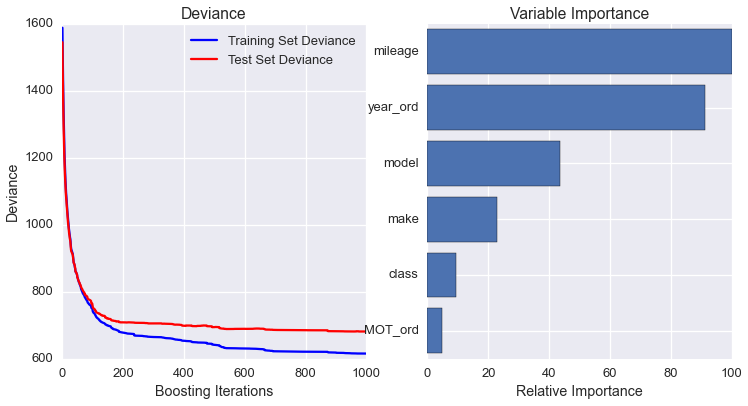

MAE: 615.8370,   MSE: 895873.0257
Loss Function: ls


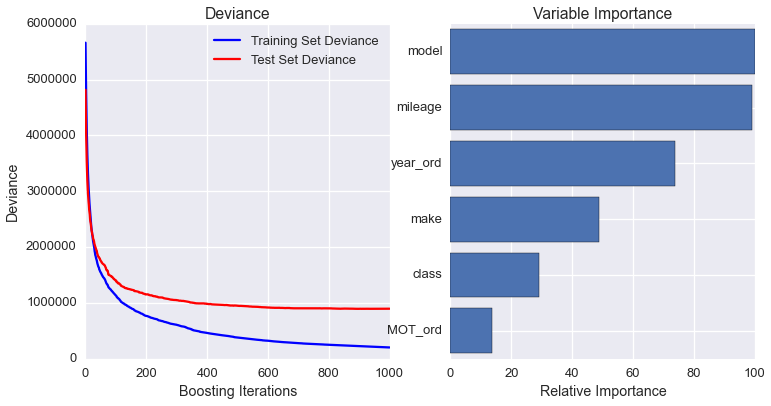

MAE: 601.4470,   MSE: 922503.2143
Loss Function: huber


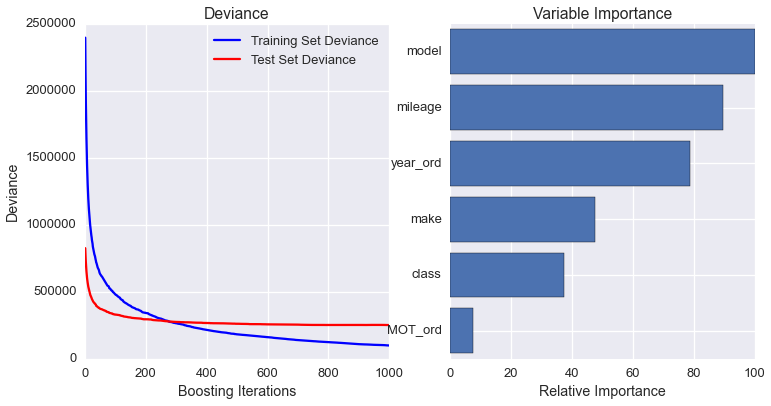

In [7]:
# Only look at one Partition of the  Data 
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, random_state=0)

### Model Batch Parameters
params_list = [{'n_estimators': 1000, 'max_depth': 3, 'min_samples_split': 5,
          'learning_rate': 0.1, 'loss': 'lad'}, 
               {'n_estimators': 1000, 'max_depth': 3, 'min_samples_split': 5,
          'learning_rate': 0.1, 'loss': 'ls'}, 
               {'n_estimators': 1000, 'max_depth': 3, 'min_samples_split': 5,
          'learning_rate': 0.1, 'loss': 'huber'}]

for params in params_list:
    
    # Initialise Regressor and fit training data 
    est = ensemble.GradientBoostingRegressor(**params)
    est.fit(X_train, y_train)

    # Log Errors Over all consecutive iterations  
    train_error = est.train_score_
    test_error = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(est.staged_predict(X_test)):
        test_error[i] = est.loss_(y_test, y_pred)
    
    mse = mean_squared_error(y_test, est.predict(X_test))
    mae = mean_absolute_error(y_test, est.predict(X_test))
    print("MAE: %.4f,   MSE: %.4f" % (mae, mse))
    print("Loss Function: {}".format(params['loss']))
    MSE_list.append(mse)
    MAE_list.append(mae)    

    # Plotting #
    # -------- #
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, est.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_error, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')

    # Plot feature importance
    feature_importance = est.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(features)[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()